In [14]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge, subtract
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.regularizers import *
from keras.initializers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

import urllib.request
import collections
import os
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from textblob import TextBlob
import http.client
import xml.dom.minidom
from sklearn.utils import shuffle
import re
import seaborn as sns
import keras
import matplotlib.pyplot as plt

In [4]:
# Obtain Dataframe object
dataFrame_obj = pd.read_csv('C:/Study/Kgl/NN_Quora/train.csv', sep=',')

In [5]:
# Replacing entries having NaN entries in Question with Clean data

missing_q_index = list(dataFrame_obj[dataFrame_obj['question1'].isnull()].id)
missing_q_index += list(dataFrame_obj[dataFrame_obj['question2'].isnull()].id)
print(missing_q_index)
quality_data_indices = list(dataFrame_obj.id)
for index in missing_q_index:
    quality_data_indices.remove(index)
for index in missing_q_index:
    import random
    if type(dataFrame_obj.question1[index]) == str:
        dataFrame_obj.question2[index] = '?';
    else:
        dataFrame_obj.question1[index] = '?';
    dataFrame_obj.is_duplicate[index] = 0;

[363362, 105780, 201841]


C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [4]:
def split_dataFrame_object(dataFrame_object):
    total_data = len(dataFrame_object)
    split_indices = np.int32(np.array([0.9,0.95,1])*total_data)
    
    train_set = dataFrame_object.iloc[0:split_indices[0]]
    validation_set = dataFrame_object.iloc[split_indices[0]:split_indices[1]]
    test_set = dataFrame_object.iloc[split_indices[1]:split_indices[2]]
    
    return (train_set, validation_set, test_set)

In [5]:
# Seperate Same and Different intent queries from data... Split them into training-validation-test sets
# finally merge both intent datasets and shuffle them

same_intent = dataFrame_obj.loc[dataFrame_obj['is_duplicate'] == 1]
diff_intent = dataFrame_obj.loc[dataFrame_obj['is_duplicate'] == 0]

same_intent_train_set, same_intent_validation_set , same_intent_test_set = split_dataFrame_object(same_intent)
diff_intent_train_set , diff_intent_validation_set , diff_intent_test_set = split_dataFrame_object(diff_intent)

train_set = shuffle(pd.concat([same_intent_train_set, diff_intent_train_set]))
validation_set = shuffle(pd.concat([same_intent_validation_set, diff_intent_validation_set]))
test_set = shuffle(pd.concat([same_intent_test_set, diff_intent_test_set]))

In [4]:
def check_for_missing_id(dataFrame_obj):
    qid1 = list(dataFrame_obj.qid1)
    qid2 = list(dataFrame_obj.qid2)
    tot_quesn = max(max(qid1),max(qid2))
    id = {}
    for i in range(len(qid1)):
        if qid1[i] in id.keys():
            pass
        else:
            id[qid1[i]] = i
    
    for i in range(len(qid2)):
        if qid2[i] in id.keys():
            pass
        else:
            id[qid2[i]] = i
            
    for i in range(1, tot_quesn + 1):
        if i in id.keys():
            pass
        else:
            print(i, ' is missing')

# To confirm whether any data or Qid is missing
check_for_missing_id(dataFrame_obj)

In [5]:
import tensorflow_hub as hub
import os
import re
import seaborn as sns

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/1" #@param ["https://tfhub.dev/google/universal-sentence-encoder/1", "https://tfhub.dev/google/universal-sentence-encoder-large/1"]

In [538]:
'''
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
'''

'\n# Import the Universal Sentence Encoder\'s TF Hub module\nembed = hub.Module(module_url)\n\n# Compute a representation for each message, showing various lengths supported.\nword = "Elephant"\nsentence = "I am a sentence for which I would like to get its embedding."\nparagraph = (\n    "Universal Sentence Encoder embeddings also support short paragraphs. "\n    "There is no hard limit on how long the paragraph is. Roughly, the longer "\n    "the more \'diluted\' the embedding will be.")\nmessages = [word, sentence, paragraph]\n\n# Reduce logging output.\ntf.logging.set_verbosity(tf.logging.ERROR)\n\nwith tf.Session() as session:\n  session.run([tf.global_variables_initializer(), tf.tables_initializer()])\n  message_embeddings = session.run(embed(messages))\n\n  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):\n    print("Message: {}".format(messages[i]))\n    print("Embedding size: {}".format(len(message_embedding)))\n    message_embedding_snippet = ", ".

In [10]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

INFO:tensorflow:Using C:\Users\INASKOT\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'C:\\Users\\INASKOT\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'C:\\Users\\INASKOT\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'C:\\Users\\INASKOT\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'C:\\Users\\INASKOT\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\

INFO:tensorflow:Initialize variable module/global_step:0 from checkpoint b'C:\\Users\\INASKOT\\AppData\\Local\\Temp\\tfhub_modules\\c6f5954ffa065cdb2f2e604e740e8838bf21a2d3\\variables\\variables' with global_step


'\nfor i, message_embedding in enumerate(np.array(message_embeddings).tolist()):\n    print("Message: {}".format(messages[i]))\n    print("Embedding size: {}".format(len(message_embedding)))\n    message_embedding_snippet = ", ".join(\n        (str(x) for x in message_embedding[:3]))\n    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))\n'

In [18]:
del embeddings, question1_list

question2_list = list(dataFrame_obj.question2)
embeddings = embed(question2_list)
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embeddings = session.run(embeddings)
qid2 = list(dataFrame_obj.qid2)
for i in range(len(question2_list)):
    d[qid2[i]] = embeddings[i]
with open('qid_to_embedding_dict.pkl', 'wb') as f:
    pickle.dump(d, f, pickle.HIGHEST_PROTOCOL)

In [2]:
with open('qid_to_embedding_dict.pkl', 'rb') as f:
    d = pickle.load(f)

In [6]:
q1_embedding = []
for i in range(len(dataFrame_obj.qid1)):
    q1_embedding.append(d[dataFrame_obj.qid1[i]])
q2_embedding = []
for i in range(len(dataFrame_obj.qid2)):
    q2_embedding.append(d[dataFrame_obj.qid2[i]])
q1_embedding = np.array(q1_embedding)
q2_embedding = np.array(q2_embedding)

In [7]:
print(len(q1_embedding), len(q2_embedding))

363861 363861


In [7]:
'''
train_data_q1_embedding = np.array([])
for i in range(len(train_set.qid1)):
    np.append(train_data_q1_embedding, d[train_set.qid1[i]])
train_data_q2_embedding = np.array([])
for i in range(len(train_set.qid2)):
    np.append(train_data_q2_embedding, d[train_set.qid2[i]])
    
val_data_q1_embedding = np.array([])
for i in range(len(validation_set.qid1)):
    np.append(val_data_q1_embedding, d[validation_set.qid1[i]])
val_data_q2_embedding = np.array([])
for i in range(len(validation_set.qid2)):
    np.append(val_data_q2_embedding, d[validation_set.qid2[i]])
'''    
test_data_q1_embedding = []
for i in range(len(test_set.qid1)):
    test_data_q1_embedding.append(d[list(test_set.qid1)[i]])
test_data_q2_embedding = []
for i in range(len(test_set.qid2)):
    test_data_q2_embedding.append(d[list(test_set.qid2)[i]])
test_data_q1_embedding = np.array(test_data_q1_embedding)
test_data_q2_embedding = np.array(test_data_q2_embedding)

NameError: name 'test_set' is not defined

In [9]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15,6))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [9]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return K.sum(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [16]:
# Network Creation
def SentencePairComparator(input_shape, qid_to_embedding_map):
    
    qid1_embedding = Input(shape=input_shape,dtype=np.float32,name="Input_Layer_Qid1")
    qid2_embedding = Input(shape=input_shape,dtype=np.float32,name="Input_Layer_Qid2")
    
    #comparision_layer = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1), inputs=[qid1_embedding, qid2_embedding])
    comparision_layer = subtract([qid1_embedding,qid2_embedding],name="Comparision_Layer")
    comparision_layer = Dense(units=32, activation='relu', kernel_regularizer=l2(0.000), bias_initializer=constant(0.1))(comparision_layer)
    comparision_layer = keras.layers.Dropout(0)(comparision_layer)
    #comparision_layer = Dense(units=32,activation='relu',kernel_regularizer=l2(0.0005), bias_initializer=constant(0.1))(comparision_layer)
    #comparision_layer = keras.layers.Dropout(0.5)(comparision_layer)
    #comparision_layer = Dense(units=16,activation='relu',kernel_regularizer=l2(0.0005), bias_initializer=constant(0.1))(comparision_layer)
    #comparision_layer = keras.layers.Dropout(0)(comparision_layer)
    
    #hidden1_dense = Dense(units=128, name="First_Hidden_Layer",activation='relu', kernel_regularizer=l2(0.005), bias_initializer=constant(0))
    #DL1           = keras.layers.Dropout(0.3)
    #hidden_1_qid1 = DL1(hidden1_dense(qid1_embedding))
    #hidden_1_qid2 = DL1(hidden1_dense(qid2_embedding))
    
    #hidden2_dense = Dense(units=32, name = "Second_Hidden_Layer", activation='relu',kernel_regularizer=l2(0.002), bias_initializer=constant(0.01))
    #DL2           = keras.layers.Dropout(0.5)
    #hidden_2_qid1 = DL2(hidden2_dense(hidden_1_qid1))
    #hidden_2_qid2 = DL2(hidden2_dense(hidden_1_qid2))
    
    #comparision_layer = subtract([hidden_2_qid1,hidden_2_qid2],name="Comparision_Layer")
    output = Dense(1,activation='sigmoid', kernel_regularizer=l2(0.00), name="Output_Layer")(comparision_layer)
    #output = keras.layers.merge([hidden_2_qid1, hidden_2_qid2], mode='cos',dot_axes=-1, output_shape=(None,1))
    #output = keras.layers.Lambda(cosine_distance,output_shape=cos_dist_output_shape)([hidden_2_qid1, hidden_2_qid2])
    #output = keras.layers.Activation('sigmoid')(output)
    
    #output = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1), inputs=[hidden_1_qid1, hidden_1_qid2])
    
    model = Model(inputs=[qid1_embedding, qid2_embedding], outputs=output)
    return model

In [17]:
model = SentencePairComparator(list(d.values())[0].shape,qid_to_embedding_map=d)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer_Qid1 (InputLayer)   (None, 512)          0                                            
__________________________________________________________________________________________________
Input_Layer_Qid2 (InputLayer)   (None, 512)          0                                            
__________________________________________________________________________________________________
Comparision_Layer (Subtract)    (None, 512)          0           Input_Layer_Qid1[0][0]           
                                                                 Input_Layer_Qid2[0][0]           
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           16416       Comparision_Layer[0][0]          
__________

In [18]:
#sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.8, amsgrad=False)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

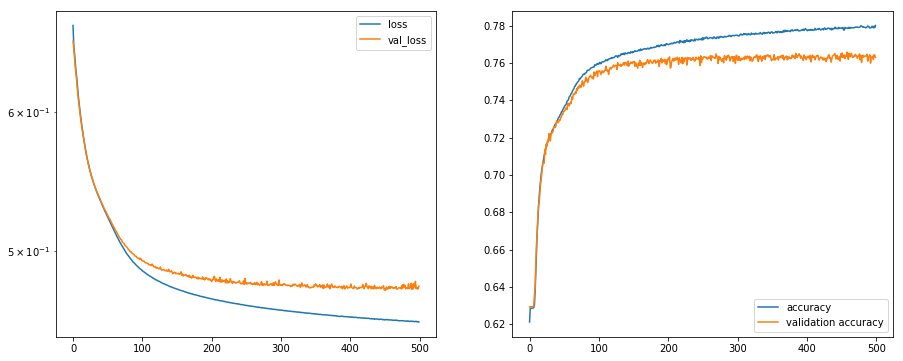

In [19]:
start_id = np.random.randint(1,150000)
stop_id  = start_id + 262272
#history = model.fit(x=[q1_embedding,q2_embedding],y=list(dataFrame_obj.is_duplicate),batch_size=256,epochs=500,shuffle=True,validation_split=0.2,verbose=2, callbacks=[plot])
checkpoint = ModelCheckpoint(filepath='GoogleUSENetWeights.{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x=[q1_embedding[start_id:stop_id],q2_embedding[start_id:stop_id]],y=list(dataFrame_obj.is_duplicate[start_id:stop_id]),batch_size=2048,epochs=500,shuffle=True,validation_split=0.2,verbose=2, callbacks=[plot,checkpoint])

In [20]:
model.evaluate(x=[test_data_q1_embedding, test_data_q2_embedding],y=list(test_set.is_duplicate),verbose=2)

NameError: name 'test_data_q2_embedding' is not defined

In [122]:
q1_embedding[5][:10]

array([ 0.02902938, -0.0112369 , -0.00246853, -0.06515623, -0.03764345,
        0.02697499,  0.00324297,  0.0461738 ,  0.02616704, -0.00604337],
      dtype=float32)

In [123]:
list(dataFrame_obj.qid1)[5]

11

In [124]:
d[11][:10]

array([ 0.02902938, -0.0112369 , -0.00246853, -0.06515623, -0.03764345,
        0.02697499,  0.00324297,  0.0461738 ,  0.02616704, -0.00604337],
      dtype=float32)